# Lezione 8 − Quadratura numerica

In questo documento mostro come implementare gli algoritmi di integrazione numerica visti durante la lezione 8. È una utile traccia per capire quali risultati dovete aspettarvi. Invece di fornire gli esempi di codice in C++, ho scelto di usare il linguaggio Julia, per i seguenti motivi:

1. Non fornendo codici C++, vi obbligo ad implementare tutto da soli;
2. Il linguaggio Julia è molto semplice da leggere, e non richiede competenze particolari per essere compreso;
3. Essendo questo un _notebook_, include sia le spiegazioni che gli esempi di codice e gli output.

Tenete conto in Julia non esiste incapsulamento, e l'ereditarietà e il polimorfismo sono implementati in maniera diversa dal C++, quindi il modo in cui sono implementati i codici è profondamente diverso. L'approccio di Julia è molto più semplice e intuitivo, e non dovrebbe essere difficile per voi capire cosa faccia il codice.

## Installazione di Julia

Questo documento è un _notebook_ creato con Jupyter, un sistema che consente di creare file che contengono testi, tabelle, immagini e parti di codice. È ad oggi il metodo più diffuso per fare analisi di dati scientifici. Jupyter è nato per supportare tre linguaggi: Julia, Python, e R (da cui il nome: Ju-Pyt-e-R), anche se sono nel tempo stati sviluppati moduli per usare altri linguaggi.

Julia è un linguaggio di programmazione moderno pensato soprattutto per la scrittura di codici numerici e scientifici. È molto più semplice del C++ e nel contempo estremamente potente. Non è consigliabile installare Julia sui computer del laboratorio, a causa dello scarso spazio disponibile nelle home. Le istruzioni in questo paragrafo possono esservi utili se desiderate installare Julia sul vostro computer.

Scaricate l'eseguibile per il vostro ambiente dal sito https://julialang.org/ (al momento la versione più recente è la 1.2, ma la 1.3 è prevista a breve). Avviate poi Julia (da Linux eseguite `julia`, mentre sotto Windows e Mac OS X dovrebbe essere presente un'icona), ed installate alcuni pacchetti che saranno utili per questa lezione e la prossima.

```julia
import Pkg
Pkg.add("PyPlot")
Pkg.add("IJulia")
```

Una volta eseguiti i comandi, potete aprire notebook esistenti e crearne di nuovi con questo codice:

```julia
import IJulia
IJulia.jupyterlab(dir=".")
```

Appena eseguita l'istruzione, dovrebbe aprirsi il vostro browser Internet (Firefox, Safari, …) e mostrare la pagina di Jupyter-Lab, l'interfaccia che consente di gestire i notebook.

## Introduzione

Iniziamo col caricare due librerie che ci serviranno. In Julia si caricano librerie col comando `import` (l'analogo di `#include` in C++):

```julia
import Statistics

# In C++ si sarebbe scritto: Statistics::mean
# ("Statistics" è un namespace)
Statistics.mean([1, 2, 3])
```

Esiste il comando `using`, che equivale alla combinazione in C++ di `#include` e `using namespace`:

```julia
using Statistics

mean([1, 2, 3])
```

Le librerie che ci interessano sono Plots (per produrre grafici, come ROOT in C++) e Printf (per scrivere valori formattati sullo schermo, come in C++ `setprecision`, `setw`, etc.)

In [1]:
using PyPlot
using Printf

Nella lezione di oggi dovremo calcolare numericamente degli integrali. Useremo come esempio la funzione $f(x) = \sin(x)$, sapendo che
$$
\int_0^\pi \sin x\,\text{d}x = 2.
$$

Useremo molto anche la capacità di Julia di creare liste al volo mediante la sintassi

```julia
result = [f(x) for x in lista]
```
che equivale al codice seguente:
```julia
result = []
for elem in lista
    append!(result, f(elem))
end
```

Vediamo un esempio: creiamo un array `prova` che contenga il quadrato dei valori `[1, 2, 3]`. In C++ avremmo dovuto scrivere

```c++
std::vector<int> list{1, 2, 3};
std::vector<int> prova(3);
for (int i = 0; i < list.size(); ++i) {
    prova[i] = list[i] * list[i];
}
```

In Julia è tutto molto più semplice:

In [2]:
prova = [x * x for x in [1, 2, 3]]

3-element Array{Int64,1}:
 1
 4
 9

## Metodo del mid-point

Il metodo del mid-point consiste nell'approssimare l'integrale con il valore del punto della funzione $f$ nel punto medio dell'intervallo:
$$
\int_a^b f(x)\,\text{d}x \approx \sum_{k=0}^{n - 1} f\Biggl(a + \left(k + \frac12\right)h\Biggr).
$$

In Julia non esistono classi, quindi non è possibile definire una classe `Integral`. Ma ciò non è necessario, perché vedremo più tardi che in Julia il polimorfismo non viene implementato tramite classi, bensì tramite il cosiddetto _multiple dispatch_, più adatto ai casi numerici e scientifici.

Non preoccupiamoci quindi di definire classi, ma implementiamo il metodo del mid-point tramite una semplice funzione `midpoint`. Non specifichiamo il tipo di `f`, né di `a` o di `b`, ma specifichiamo quello di `n`: il motivo sarà chiaro quando risolveremo l'esercizio 8.2. Il tipo `Integer` è l'analogo di una classe astratta in C++, ed è il padre di tutti quei tipi che rappresentano numeri interi (`Int`, `Int8`, `UInt32`, etc.). Stiamo in pratica dicendo a Julia che `midpoint` può accettare qualsiasi tipo di valore per `f`, `a` e `b`, ma `n` deve essere un numero intero.

In [3]:
function midpoint(f, a, b, n::Integer)
    h = (b - a) / n
    h * sum([f(a + (k + 0.5) * h) for k in 0:(n - 1)])
end

midpoint (generic function with 1 method)

Verifichiamone il funzionamento:

In [4]:
midpoint(sin, 0, pi, 10)

2.0082484079079745

Questo caso è utile per implementare nel vostro codice C++ un `assert`:

```c++
const double REF_A = 0.0;
const double REF_B = M_PI;
const double REF_INTEGRAL = 2.0082484079;

int main(void) {
    Seno mysin();
    Integrator integrator(REF_A, REF_B, &mysin);
    assert(fabs(integrator.MidPoint(10) - REF_INTEGRAL) < 1e-7);
}
```

In [5]:
midpoint(sin, 0, pi, 100)

2.000082249070986

In [6]:
midpoint(sin, pi, 0, 10)

-2.0082484079079745

Notate la semplicità con cui è stata chiamata la funzione: a differenza della programmazione OOP in C++, qui non abbiamo dovuto creare una classe `Seno` con un metodo `Eval` che chiamasse `sin`. È stato sufficiente invocare `midpoint` passandole `sin` come primo argomento.

Il caso $\int_0^\pi \sin(x)\,\mathrm{d}t$ è troppo particolare per poter essere un buon caso per i test, perché (1) l'estremo inferiore è zero, e (2) la funzione si annulla negli estremi di integrazione. Alcune formule di integrazione che vedremo oggi richiedono un trattamento speciale agli estremi di integrazione, e un caso come questo potrebbe far passare inosservati dei bug importanti (**è successo in passato**!). Calcoliamo il valore dell'integrale con questo algoritmo in due casi più rappresentativi: $$\int_0^1 \sin(x)\,\mathrm{d}t, \quad \int_1^2 \sin(x)\,\mathrm{d}t.$$

In [7]:
midpoint(sin, 0, 1, 10)

0.45988929071851814

In [8]:
midpoint(sin, 1, 2, 30)

0.9564934239032155

In C++ potremmo quindi scrivere il `main` del nostro programma con due istruzioni che verifichino il funzionamento del metodo `MidPoint` su questi due casi:

```c++
int main(void) {
    Seno mysin();
    Integrator integrator(&mysin);

    assert(fabs(integrator.MidPoint(0, 1, 10)
                - 0.45988929071851814) < 1e-7);
    
    integrator.set_a(1);
    Integrator.set_b(2);
    assert(fabs(integrator.MidPoint(1, 2, 30)
                - 0.9564934239032155) < 1e-7);
}
```

### Errore del metodo mid-point

Calcoliamo ora l'andamento dell'errore rispetto alla funzione di riferimento $f(x) = \sin x$.

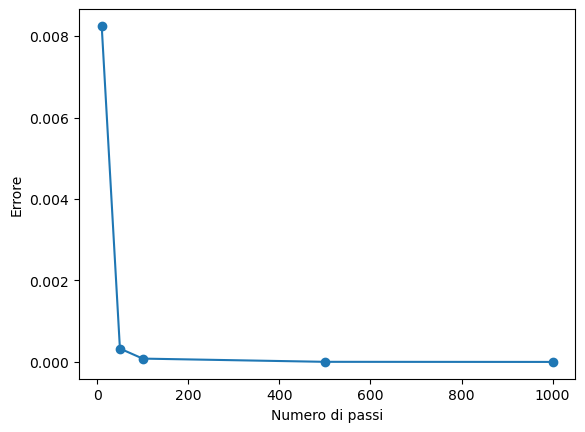

PyObject Text(24.0, 0.5, 'Errore')

In [9]:
steps = [10, 50, 100, 500, 1000]
errors = [abs(midpoint(sin, 0, pi, n) - 2) for n in steps]

plot(steps, errors, "o-")
xlabel("Numero di passi")
ylabel("Errore")

Il grafico precedente non è chiaro perché ci sono escursioni di alcuni ordini di grandezza sia per la variabile $x$ che per la variabile $y$. Usiamo allora un grafico bilogaritmico, in cui si rappresentano i punti $(x', y') = (\log x, \log y)$ anziché $(x, y)$. Questo è l'ideale per i grafici di leggi del tipo $y = x^\alpha$, come si vede da questi conti:
$$
\begin{split}
y &= C x^\alpha,\\
\log y &= \log \bigl(C x^\alpha\bigr),\\
\log y &= \alpha \log x + \log C,\\
y' &= \alpha x' + \log C,
\end{split}
$$
che è della forma $y' = m x' + q$, ossia una retta, dove il coefficiente angolare $m$ è proprio $\alpha$.

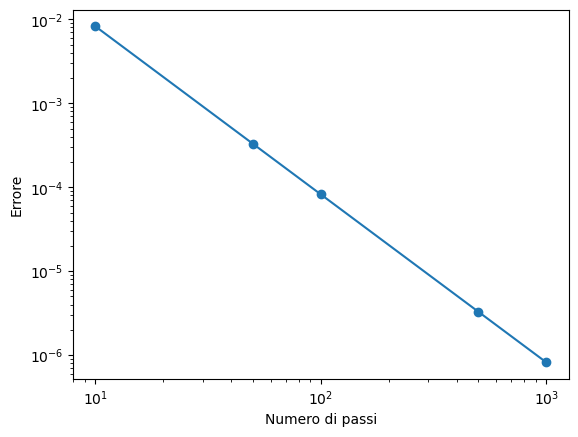

PyObject Text(24.000000000000007, 0.5, 'Errore')

In [10]:
loglog(steps, errors, "o-")
xlabel("Numero di passi")
ylabel("Errore")

Nel vostro codice vorrete probabilmente usare ROOT per creare un grafico come questo. Siccome la realizzazione di grafici in ROOT può essere complessa, il mio consiglio è quello di stampare dapprima i numeri in un file (oppure a video, reindirizzando l'output da linea di comando con il carattere `>`), e poi fare una veloce visualizzazione con Gnuplot.

Il programma Gnuplot è installato su tutti i computer del laboratorio, e si avvia da terminale eseguendo `gnuplot`. Dal prompt dei comandi potete creare un grafico come quello sopra scrivendo queste righe:

    set logscale xy
    plot 'dati.txt' using 1:2 with linespoints
    
Ovviamente il file `dati.txt` è quello generato dal vostro programma, e deve essere stato prodotto da un codice del genere:

```c++
std::vector<int> steps_list{10, 50, 100, 500, 1000};
std::ofstream file;

file.open("dati.txt");

for(int num_of_steps: steps_list) {
    double error = …; // Calcolo in "error" l'errore di "midpoint"
    
    // Stampo il numero di passi, uno spazio vuoto, e l'errore
    file << num_of_steps << " " << fabs(error) << "\n";
}
```

Quando avrete verificato che il plot è simile a quello mostrato sopra, potrete a questo punto implementare il codice per disegnare grafici con ROOT.

Implementiamo ora una funzione che consenta di calcolare rapidamente l'errore di una funzione di integrazione numerica per un dato numero di passi di integrazione: ci servirà per studiare non solo il metodo del mid-point, ma anche i metodi di Simpson e dei trapezi.

Inizializziamo per prima cosa le costanti che caratterizzano il caso che useremo come esempio, $\int_0^\pi \sin x\,\text{d}x = 2$: la funzione da integrare (`REF_FN`), gli estremi (`REF_A` e `REF_B`), e il valore esatto dell'integrale (`REF_INT`).

In [11]:
const REF_FN = sin;  # La funzione da integrare
const REF_A = 0;     # Estremo inferiore di integrazione
const REF_B = pi;    # Estremo superiore di integrazione
const REF_INT = 2.;  # Valore dell'integrale noto analiticamente

La funzione `compute_errors` calcola il valore assoluto della differenza tra la stima dell'integrale con la funzione `fn` (che può essere ad esempio `midpoint`) e il valore vero dell'integrale, `REF_INT`.

In [12]:
compute_errors(fn, steps) = [abs(fn(REF_FN, REF_A, REF_B, n) - REF_INT)
                             for n in steps]

compute_errors (generic function with 1 method)

Applichiamo `compute_errors` alla funzione `midpoint`:

In [13]:
errors = compute_errors(midpoint, steps)

5-element Array{Float64,1}:
 0.008248407907974542
 0.0003290246986251688
 8.224907098597356e-5
 3.2898719215523897e-6
 8.224672694012725e-7

Come ricavare la legge di potenza dovrebbe essere ovvio dal discorso fatto sopra circa i grafici bilogaritmici…

In [14]:
function error_slope(steps, errors)
    deltax = log(steps[end]) - log(steps[1])
    deltay = log(errors[end]) - log(errors[1])

    deltay / deltax
end

error_slope(steps, errors)

-2.0006257529986535

**Domanda 1**: È importante nell'implementazione di `error_slope` sopra fissare la base del logaritmo, oppure no? In altre parole, si ottengono risultati diversi se si usa $\log_2$, $\log_{10}$, o $\ln$?

**Domanda 2**: In quali casi l'implementazione di `error_slope` può dare valori scorretti?

## Metodo di Simpson

Si usa la formula
$$
\int_a^b f(x)\,\text{d}x = \left(\frac13 f(x_0) + \frac43 f(x_1) + \frac23 f(x_2) + \ldots + \frac43 f(x_{N - 2}) + \frac13 f(x_{N - 1})\right) h,
$$
con $x_k = a + kh$.

Come sopra, implementiamo l'algoritmo senza definire classi, ma scrivendo direttamente una funzione.

In [15]:
function simpson(f, a, b, n::Integer)
    # Siccome il metodo funziona solo quando il numero di
    # intervalli è pari, usiamo "truen" anziché "n" nei
    # calcoli sotto
    truen = (n % 2 == 0) ? n : (n + 1)
    
    h = (b - a) / truen
    acc = 1/3 * (f(a) + f(b))
    for k = 1:(truen - 1)
        acc += 2/3 * (1 + k % 2) * f(a + k * h)
    end
    
    acc * h
end

simpson (generic function with 1 method)

Verifichiamone il funzionamento sul nostro caso di riferimento. Anche questi numeri sono utili per implementare degli `assert` nel vostro codice C++; in particolare, il metodo di Simpson tratta in modo diverso gli estremi $f(a)$ e $f(b)$, quindi il secondo e il terzo test sono particolarmente importanti!

In [16]:
simpson(sin, 0, pi, 10)

2.0001095173150043

In [17]:
simpson(sin, 0, pi, 100)

2.000000010824504

In [18]:
simpson(sin, 0, 1, 10)

0.45969794982382056

In [20]:
simpson(sin, 1, 2, 30)

0.9564491489761575

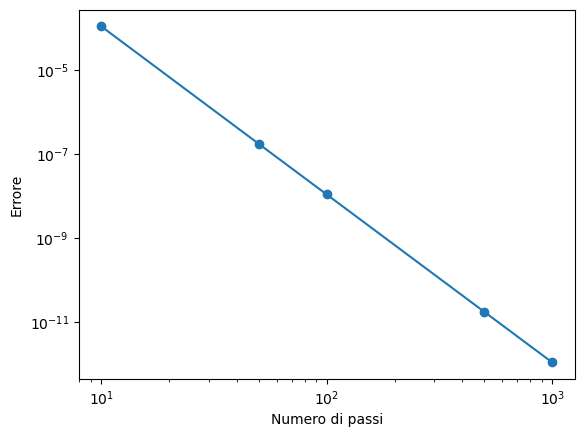

PyObject Text(24.000000000000007, 0.5, 'Errore')

In [21]:
errors = compute_errors(simpson, steps)

loglog(steps, errors, "o-")
xlabel("Numero di passi")
ylabel("Errore")

In [22]:
error_slope(steps, errors)

-4.002400383183911

## Metodo dei trapezoidi

In questo caso si approssima l'integrale con l'area del trapezio.

In [23]:
function trapezoids(f, a, b, n::Integer)
    h = (b - a) / n
    acc = (f(a) + f(b)) / 2
    for k in 1:(n - 1)
        acc += f(a + k * h)
    end
    
    acc * h
end

trapezoids (generic function with 1 method)

In [24]:
trapezoids(sin, 0, pi, 10)

1.9835235375094546

In [25]:
trapezoids(sin, 0, pi, 100)

1.9998355038874436

In [26]:
trapezoids(sin, 0, 1, 10)

0.45931454885797635

In [27]:
trapezoids(sin, 1, 2, 30)

0.956360580669458

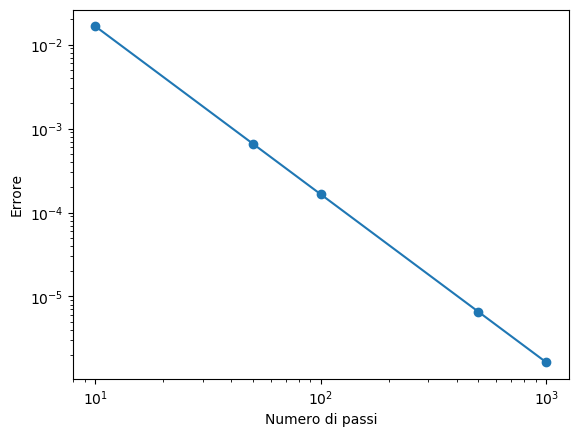

PyObject Text(24.000000000000007, 0.5, 'Errore')

In [25]:
errors = compute_errors(trapezoids, steps)
loglog(steps, errors, "o-")
xlabel("Numero di passi")
ylabel("Errore")

In [26]:
error_slope(steps, errors)

-2.000357703753135

Tracciamo ora un grafico comparativo dei due metodi. È importante notare ancora una volta che qui stiamo usando il polimorfismo senza usare classi né metodi `virtual`. La funzione `compute_errors` infatti adatta il proprio comportamento a seconda della funzione che le viene passata come argomento (sia essa `midpoint`, `simpson`, o `trapezoids`).

Notate che anche in C++ è possibile avere polimorfismo senza usare classi, usando i template. Ma c'è una differenza importante: il polimorfismo con le classi è realizzato in fase di _runtime_ in C++, mentre quello con i template è realizzato in fase di _compilazione_. In Julia non c'è una distinzione rigida, e a seconda dei casi il compilatore sceglie se implementare il polimorfismo in fase di compilazione o runtime.

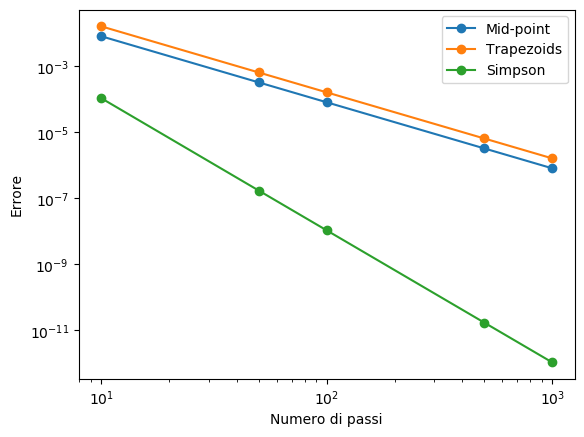

In [27]:
for (label, fn) in [
    ("Mid-point", midpoint),
    ("Trapezoids", trapezoids),
    ("Simpson", simpson),
]
    # All'interno di questo ciclo "for" sono definite le
    # due variabili "label" e "fn", che assumono uno dopo l'altro
    # il valore delle coppie elencate sopra tra parentesi. Notate
    # come in Julia sia semplicissimo iterare addirittura su liste
    # che contengono funzioni!
    loglog(steps, compute_errors(fn, steps), "o-", label=label)
end

xlabel("Numero di passi")
ylabel("Errore")
legend();

Notate che il metodo del mid-point e dei trapezi hanno la stessa legge di scala, ma non si sovrappongono: la costante $C$ nella legge di scala $\epsilon = C n^{-\alpha}$ è diversa (e quindi è diversa l'intercetta $q = \log C$ nel grafico bilogaritmico).

## Ricerca della precisione

L'esercizio 8.2 è diverso dagli esercizi 8.0 e 8.1, perché richiede di iterare il calcolo finché non si raggiunge una precisione fissata. Usiamo il suggerimento del testo per non dover ricalcolare da capo il valore approssimato dell'integrale.

Sfruttiamo la capacità di Julia di esprimere sequenze con la sintassi `start:delta:end`:

In [28]:
collect(1:2:10)

5-element Array{Int64,1}:
 1
 3
 5
 7
 9

Ora appare chiaro perché nell'implementare `midpoint`, `simpsons` e `trapezoids` sopra avevamo dichiarato esplicitamente il tipo dell'ultimo parametro, `n`: in questo caso vogliamo infatti invocare `trapezoids` usando la precisione, che indichiamo col tipo `AbstractFloat`, analogo a una classe astratta C++ da cui derivano i tipi floating-point, come `Float16`, `Float32`, e `Float64`.

In [29]:
function trapezoids(f, a, b, prec::AbstractFloat)
    n = 2
    
    h = (b - a) / n
    # Valore dell'integrale nel caso n = 2
    acc = (f(a) + f(b)) / 2 + f((a + b) / 2)
    newint = acc * h
    while true
        oldint = newint
        n *= 2
        h /= 2
        
        for k in 1:2:(n - 1) # Itera solo sui numeri dispari
            acc += f(a + k * h)
        end
        
        newint = acc * h
        # 4//3 è la frazione 4/3 in Julia
        if 4//3 * abs(newint - oldint) < prec
            break
        end
    end
    
    newint
end

trapezoids (generic function with 2 methods)

Notate che dopo aver compilato la definizione precedente, Julia ha scritto `trapezoids (generic function with 2 methods)`. Ha quindi capito che abbiamo fornito una nuova implementazione di `trapezoids`, e non ha quindi sovrascritto la vecchia (che accettava come ultimo argomento un intero, ossia il numero di passaggi).

Per verificare il funzionamento della nuova funzione `trapezoids`, possiamo verificare che l'integrale calcolato sulla nostra funzione di riferimento $f(x) = \sin x$ abbia un errore sempre inferiore alla precisione richiesta.

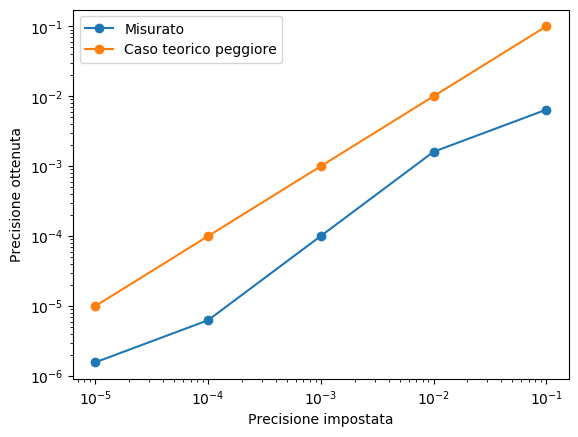

In [30]:
prec = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
errors = [abs(trapezoids(REF_FN, REF_A, REF_B, eps) - REF_INT)
          for eps in prec]

loglog(prec, errors, "o-", label="Misurato")
loglog(prec, prec, "o-", label="Caso teorico peggiore")
xlabel("Precisione impostata")
ylabel("Precisione ottenuta")
legend();